# Exploratory Data Analysis

In [44]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

df = pd.read_csv('MetacriticGameReviewsClean.csv', index_col=0)
df.head()

,title,platform,metascore,metasentiment,average_userscore,average_usersentiment,developer,genre,number_of_players,esrb_rating,release_date,username,userscore,usersentiment,review,review_date,clean_text,language,number_of_words,number_of_sentences
0,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,"Oct 26, 2018",gnadenlos,7,mixed,"The main problem is, that it's not a real open...","Nov 1, 2018",main problem not real open world focus main st...,en,178,9
1,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,"Oct 26, 2018",Feriatus,7,mixed,It's not a bad game but the gameplay is an out...,"Oct 29, 2018",not bad gameplay outdated one no mean realism ...,en,79,6
2,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,"Oct 26, 2018",ponux,7,mixed,"Visually superb (except cutscenes), good (not ...","Nov 5, 2018",visually superb except cutscenes good not amaz...,en,351,20
3,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,"Oct 26, 2018",Picklock,5,mixed,"Great looking game backed up by clumsy, overly...","Nov 4, 2018",great looking backed clumsy overly complicated...,en,352,17
4,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,"Oct 26, 2018",Saints,6,mixed,Red Dead Redemption 2 is an amazing game that ...,"Oct 30, 2018",red dead redemption amazing plagued outdated c...,en,614,32


### Determine the distribution of user scores

Text(0, 0.5, 'Percentage')

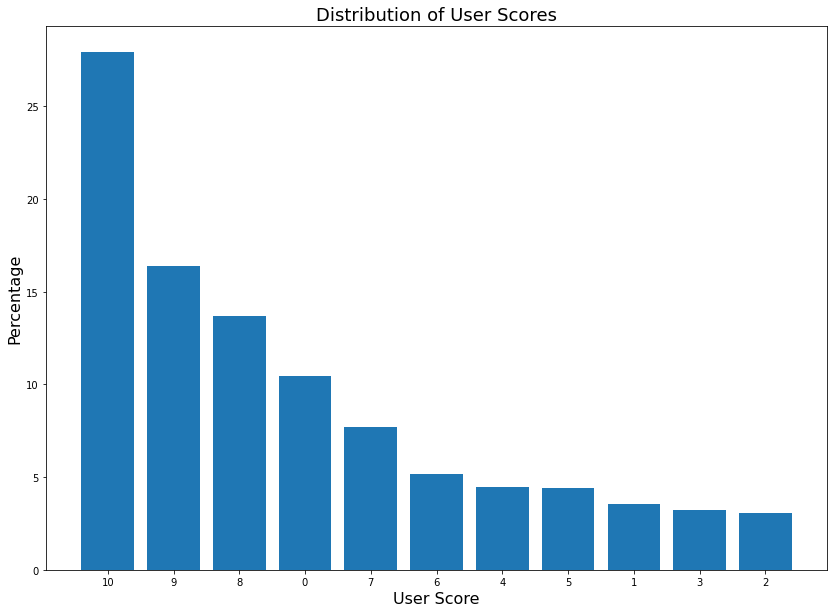

In [19]:
percent_userscore = [round(val*100, 2) for val in df.userscore.value_counts(normalize=True).values]
score = [str(i) for i in df.userscore.value_counts().index]

# Plot the distribution of number of words by user score for each game genre
plt.figure(figsize=(14,10))
plt.bar(x=score, height=percent_userscore)
plt.title('Distribution of User Scores', fontsize=18)
#plt.xticks(label=score)
plt.xlabel('User Score', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

In [20]:
print(percent_userscore)
print(score)

[27.93, 16.38, 13.71, 10.43, 7.72, 5.16, 4.44, 4.41, 3.57, 3.21, 3.05]
['10', '9', '8', '0', '7', '6', '4', '5', '1', '3', '2']


Most of the reviews in the dataset were positive accounting for about 57% of the total reviews. A whopping 10% of all reviews received a 0. People tend to enjoy video games released on console or they tend to be easily pleased with the attributes game developers add to their games. 

### Which game genre do gamers enjoy the most?

Text(0.5, 1.0, 'Distribution of User Scores by Genre')

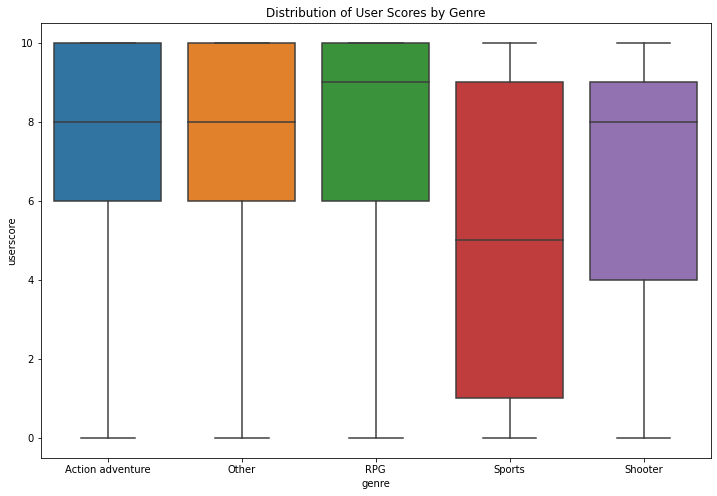

In [24]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='genre', y='userscore', data=df)
ax.set_title('Distribution of User Scores by Genre')

In [28]:
# Initialize a list of the game genres
genres = df.genre.value_counts().index
genres

Index(['Other', 'Action adventure', 'RPG', 'Shooter', 'Sports'], dtype='object')

In [ ]:
# Initialize a list of the game genres
genres = df.genre.value_counts().index

# Loop over the genres and perform an ANOVA test to check for statistical signficant findings
for genre in genres:

    stat, p = ss.f_oneway(pos, mix, neg) 
    
    if p < 0.05: #using 95% confidence interval, can be adjusted for different values
        print("There is a statistically significant difference between length of reviews and user scores in the", genre, " genre.\nP-value:{p}.\n".format(p =p))
    else:
        print("Theer is not a statistically significant difference among user scores and the length of their reviews for the", genre, "genre.")
        print('P-value:',p,'\n')

### How are sigleplayer games received by gamers than multiplayer games in each genre?

Text(0.5, 1.0, 'Distribution of User Scores by Genre Between Single/Multiplayers')

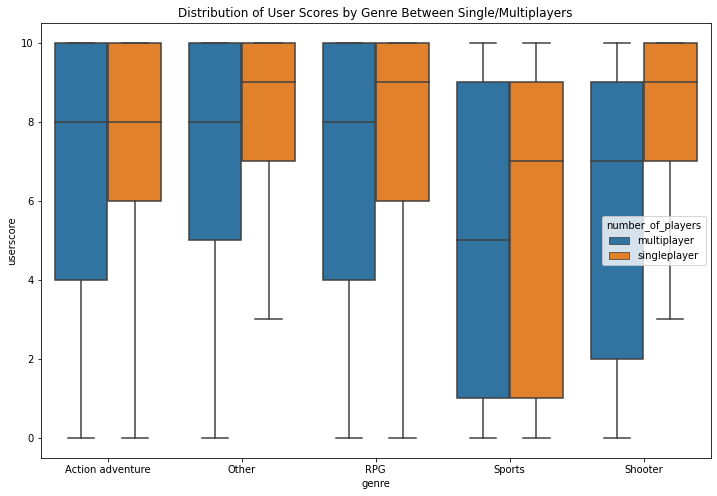

In [22]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='genre', y='userscore', hue='number_of_players', data=df, showfliers=False)
ax.set_title('Distribution of User Scores by Genre Between Single/Multiplayers')

In [34]:
#We can perform a t-test and calculate p-values to verify which traits are statistically significant to nicotine consumption
for genre in genres:
    single = df.loc[df['genre'] == genre, 'userscore'][df.number_of_players == 'singleplayer']
    multi = df.loc[df['genre'] == genre, 'userscore'][df.number_of_players == 'multiplayer']

    stat, p = ss.ttest_ind(single, multi) 
    
    if p < 0.05: #using 95% confidence interval, can be adjusted for different values
        print("There is a statistically significant difference between multi and single player games and user scores in the", genre, "genre.\nP-value:{p}.\n".format(p =p))
    else:
        print("The", genre, "genre is not statistically significant between multi and single player games and user scores.")
        print('P-value:',p,'\n')

There is a statistically significant difference between multi and single player games and user scores in the Other genre.
P-value:1.1532355934745548e-09.

There is a statistically significant difference between multi and single player games and user scores in the Action adventure genre.
P-value:4.720764106915352e-16.

There is a statistically significant difference between multi and single player games and user scores in the RPG genre.
P-value:5.962644605649012e-10.

There is a statistically significant difference between multi and single player games and user scores in the Shooter genre.
P-value:1.7482594476121354e-38.

There is a statistically significant difference between multi and single player games and user scores in the Sports genre.
P-value:0.03868216633581247.



In [ ]:
# SCATTER PLOT OF number of words and sentences
# NGRAMS


### Are positive user reviews longer than negative ones? Do they differ based on game genre?

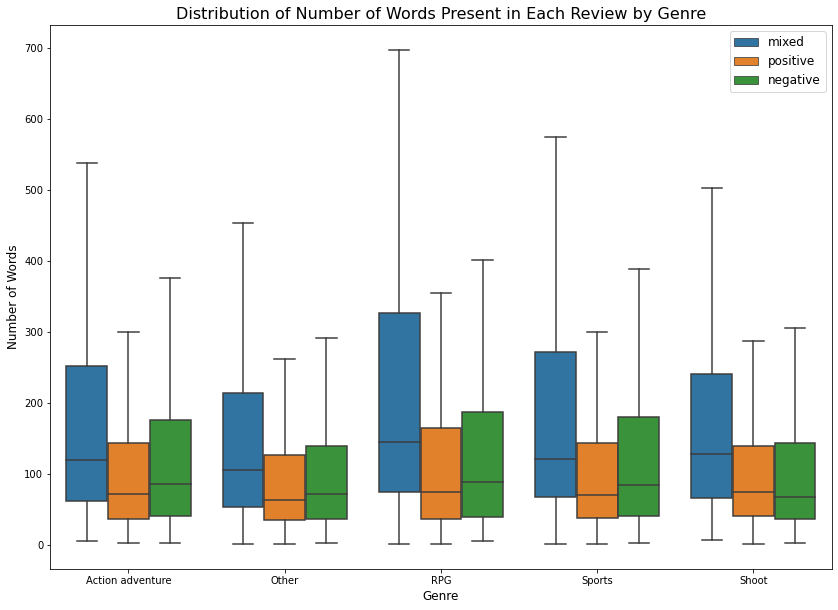

In [45]:
# Plot the distribution of number of words by user score for each game genre
plt.figure(figsize=(14,10))
ax = sns.boxplot(x='genre', y='number_of_words', hue='usersentiment', data=df, showfliers=False)
ax.set_title('Distribution of Number of Words Present in Each Review by Genre', fontsize=16)
plt.legend(fontsize='large')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.show()

In [46]:
# Initialize a list of the game genres
genres = df.genre.value_counts().index

# Loop over the genres and perform an ANOVA test to check for statistical signficant findings
for genre in genres:
    pos = df.loc[df['genre'] == genre, 'number_of_words'][df.usersentiment == 'positive'].values
    mix = df.loc[df['genre'] == genre, 'number_of_words'][df.usersentiment == 'mixed'].values
    neg = df.loc[df['genre'] == genre, 'number_of_words'][df.usersentiment == 'negative'].values

    stat, p = ss.f_oneway(pos, mix, neg) 
    
    if p < 0.05: #using 95% confidence interval, can be adjusted for different values
        print("There is a statistically significant difference between length of reviews and user scores in the", genre, " genre.\nP-value:{p}.\n".format(p =p))
    else:
        print("Theer is not a statistically significant difference among user scores and the length of their reviews for the", genre, "genre.")
        print('P-value:',p,'\n')

There is a statistically significant difference between length of reviews and user scores in the Other  genre.
P-value:8.196101560237771e-29.

There is a statistically significant difference between length of reviews and user scores in the Action adventure  genre.
P-value:1.056337295809172e-33.

There is a statistically significant difference between length of reviews and user scores in the RPG  genre.
P-value:1.4022801910230443e-27.

There is a statistically significant difference between length of reviews and user scores in the Shoot  genre.
P-value:6.910435813462124e-21.

There is a statistically significant difference between length of reviews and user scores in the Sports  genre.
P-value:8.393741539386122e-14.



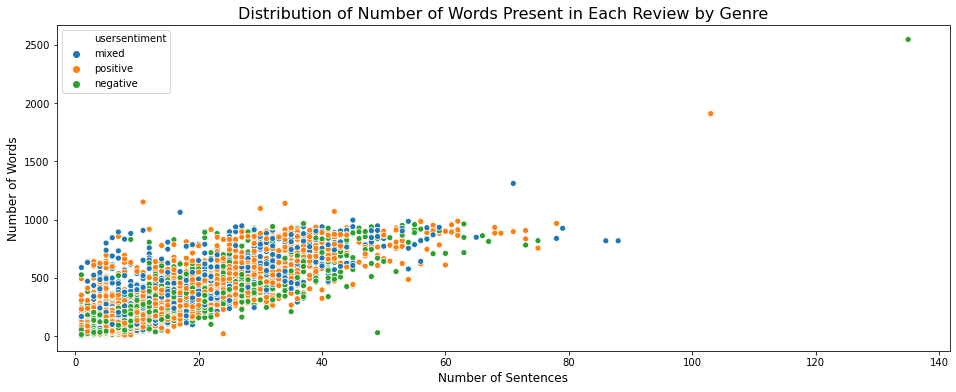

In [64]:
## Plot the distribution of number of words by user score for each game genre
#plt.figure(figsize=(14,12))
ax = sns.scatterplot(x='number_of_sentences', y='number_of_words', hue='usersentiment', data=df)
ax.set_title('Distribution of Number of Words Present in Each Review by Genre', fontsize=16)
plt.xlabel('Number of Sentences', fontsize=12)
plt.xlim(left=-3)
plt.ylabel('Number of Words', fontsize=12)
plt.show()

### What are the most common words in game reviews by genre?

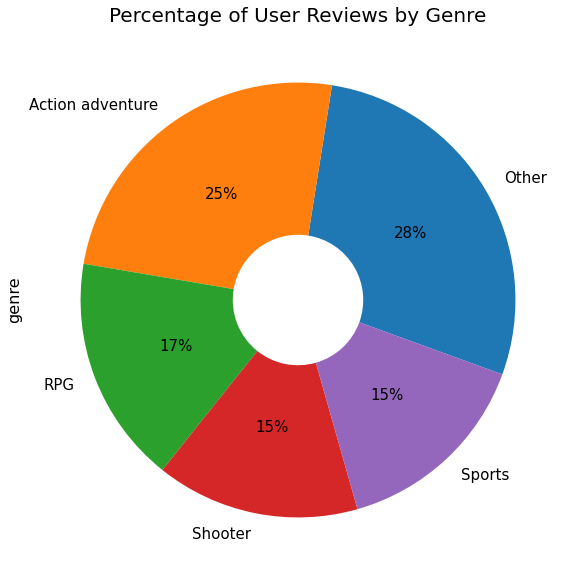

In [7]:
# Change the genre of shoot to shooter
df['genre'] = df.genre.replace('Shoot', 'Shooter')

plt.figure(figsize=(20,10))
plt.title("Percentage of User Reviews by Genre", fontsize=20)
plt.ylabel('Genre',fontsize=16)
df.genre.value_counts().plot(kind='pie', labels=['Other','Action adventure','RPG','Shooter','Sports'],
                                     wedgeprops=dict(width=.7), autopct='%1.0f%%',
                                     startangle= -20, textprops={'fontsize': 15})

Reviews for genres other than action adventure, role-playing games, shooters and sports account for the majority of the reviews consisting of 28% of the data. The aforementioned genres do not trail far behind with a healthy amount of representation for each.

In [8]:
# Initialize a series called review containing the cleaned reviews
reviews = df.clean_text

# Instantiate the BOW vectorizer
cv = CountVectorizer(max_features=200, min_df=1000, max_df=0.75)

# Fit and transform the reviews, then make them to a dataframe
bow = cv.fit_transform(reviews)
reviewsBOW = pd.DataFrame(bow.toarray(), columns=cv.get_feature_names())

In [9]:
# Concatenate the BOW reviews with their genre
genreBOW = pd.concat([df.genre, reviewsBOW], axis=1)

# Create a list containing all words generated by the BOW vectorizer
words_col = list(genreBOW.columns)
words_col.remove('genre')

# Pivot the genre and BOW's to find the count of each word present in reviews by their game genre
data = pd.pivot_table(genreBOW, index='genre', values=words_col, aggfunc=np.sum)
#data.head()

,absolutely,action,actually,add,almost,already,also,always,amazing,another,...,way,weapon,well,without,work,world,worth,would,year,yet
genre,,,,,,,,,,,,,,,,,,,,,
Action adventure,304,520,526,284,332,283,1373,377,722,457,...,1284,510,1299,444,469,1316,553,1676,576,292
Other,312,328,431,314,329,273,1362,377,584,411,...,1211,279,1273,377,604,777,632,1638,535,307
RPG,224,315,369,209,300,243,966,272,469,300,...,908,474,971,326,362,1074,405,1171,436,207
Shooter,152,200,287,217,203,180,703,254,342,257,...,651,708,674,264,298,436,355,971,396,195
Sports,210,61,347,202,260,174,742,299,256,301,...,685,15,615,284,337,247,229,1013,1468,230


In [10]:
# Transpose the pivoted data to facilitate looping over it and extracting the top words
data = data.T

# Create a dictionary of the top 50 words present in each review by genre
top_words_dict = {}
for col in data.columns:
    top = data[col].sort_values(ascending=False).head(50)
    top_words_dict[col] = list(zip(top.index, top.values))

In [11]:
# Print the top 15 words present in game reviews by genre
for genre, words in top_words_dict.items():
    print(genre)
    print(','.join([word for word, count in words[:14]]), '\n')

Action adventure
not,like,story,one,game,time,good,get,really,play,character,no,fun,great 

Other
not,like,game,play,one,time,story,get,character,really,good,great,fun,no 

RPG
not,like,story,character,one,time,get,good,game,no,really,play,great,combat 

Shooter
not,like,play,one,get,fun,time,game,good,no,really,story,feel,great 

Sports
not,like,play,player,mode,no,get,time,year,game,one,even,good,make 



All reviews by genre contain 'not', 'like', 'play', etc. To paint a clearer picture of what users really enjoyed/disliked about certain game genres, words common in more than 3 genres are added to the stop word list for EDA.

In [12]:
# Look at the most common top words and add them to stop words list
from collections import Counter

# Retrieve all 50 words present in reviews for each genre
words = []
for col in data.columns:
    top = [word for (word, count) in top_words_dict[col]]
    for t in top:
        words.append(t)

# If a word is present in more than 3 genres it is considered a genre review specific stop word
genre_stop_words = [word for word, count in Counter(words).most_common() if count > 3]
#genre_stop_words

In [13]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')

# Add new stop words
stop_words = stopwords.words('english')
stop_words.extend(genre_stop_words)
# Include other words that add no value
stop_words.extend(['video','game','de','le'])

# Recreate bag of words for reviews and pivot data by genre
cv = CountVectorizer(max_features=200, min_df=1000, max_df=0.75, stop_words=stop_words)
bow = cv.fit_transform(reviews)
reviewsBOW = pd.DataFrame(bow.toarray(), columns=cv.get_feature_names())
genreBOW = pd.concat([df.genre, reviewsBOW], axis=1)
words_col = list(genreBOW.columns)
words_col.remove('genre')
data = pd.pivot_table(genreBOW, index='genre', values=words_col, aggfunc=np.sum).T

In [14]:
# Explore the top words without genre specific stop words
top_words_dict = {}
for col in data.columns:
    top = data[col].sort_values(ascending=False).head(50)
    top_words_dict[col] = list(zip(top.index, top.values))
    
#top_words_dict

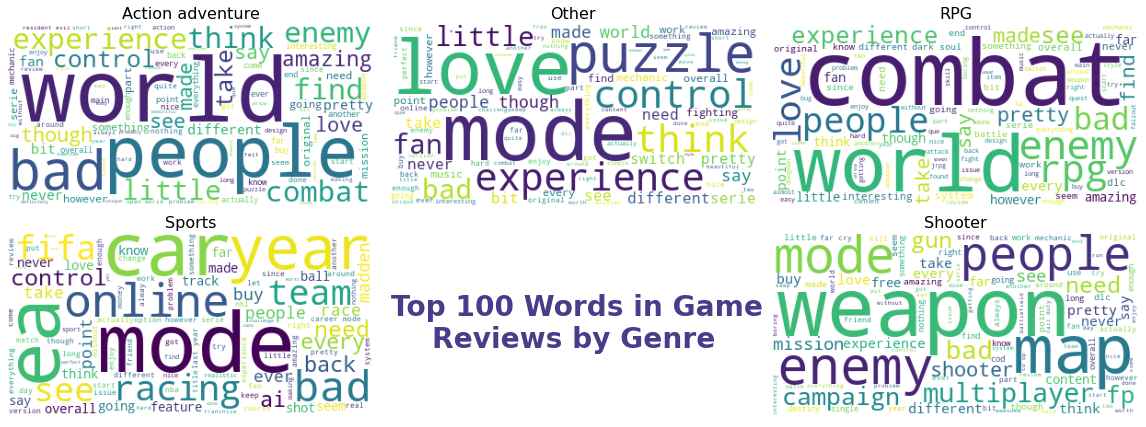

In [15]:
# Initialize wordcloud object
wc = WordCloud(stopwords=stop_words, background_color='white', random_state=1, max_words=100)

# Seperate documents by genre
genreReviews = {}
for g in pd.unique(df.genre):
    genreReviews[g] = ' '.join(df[df.genre == g].clean_text)

# Loop over genre and reviews to create word clouds for each
plt.rcParams['figure.figsize'] = [16, 6]
idx = 1

# Create iterator objects for subplot
genre = iter(genreReviews.keys())
reviews = iter(genreReviews.values())

# Create a subplot for each genre's word cloud
for i in range(1,7):
    if i == 5:
        plt.subplot(2,3,i)
        plt.text(0.005, 0.55, 'Top 100 Words in Game', fontsize=28, fontweight='bold', color='darkslateblue')
        plt.text(0.115, 0.385, 'Reviews by Genre', fontsize=28, fontweight='bold', color='darkslateblue')
        plt.axis("off")
        plt.tight_layout(pad=1)
    else:
        wc.generate(next(reviews))        
        plt.subplot(2,3,i)
        plt.imshow(wc) 
        plt.axis("off") 
        plt.tight_layout(pad = 1)
        plt.title(next(genre), fontsize=16)

plt.show()

'World' seemed to be the most common subject in action adventure reviews. 'People' is also mentioned but it is not clear what the context may be. There are many descriptive words in the cloud with the largest being the word 'bad'.

In other genres reviews mentioned 'mode' the most probably referring to vast game modes presented in other game genres. The 'puzzle' games genre may seem to be the one these reviews are mainly about. Different words that may suggest thought provoking obstacles are present in this cloud.

'Combat' is the most prominent topic in RPG reviews, along with 'world' and 'enemy'. These attributes are common in RPG games and are probably what users enjoy the most about them. The word 'pretty' stands out, most likely in reference to the scenery typical of RPG games.

Sport game reviews have 'mode' as the most common word, maybe due to the different number of game modes sport games offer. Racing games were considered as the sport genre in this project and explains why 'car' is a common word. 'Year' makes sense as new iterations of sport games series particularly develped by EA come out each year.

Not surprisingly 'weapon' is the most common word in shooter games. Other topics that were common throughout reviews were 'map'. 'enemy', 'people' and 'multiplayer'. These words could be in reference to the online multiplayer shooter games are known for.

### Which topics were most present among reviews by game genre?